### Midterm 1 Project, Problem 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

### Methodology

We consider a target function:

$u_g(x) = \sin(2x + 1) + 0.2e^{1.3x}$

1. We generate training data by sampling 300 data points from it without noise, uniformly distributed within the domain $x \in [-1, 1]$.

2. To fit the training data, we use a fully-connected neural network made of 3 hidden layers each with 20 units and use hyperbolic tangent (tanh) as the activation function.


In [8]:
# Target function (Equation (2) from the Lecture)
def target_function(x):
    return np.sin(2 * x + 1) + 0.2 * np.exp(1.3 * x)

# Generate training data (300 points in the range [-1, 1])
x_train = np.linspace(-1, 1, 300)
y_train = target_function(x_train)

# Define the neural network model (with custom layers)
def create_model(layers):
    model = Sequential()
    # Use RandomNormal initialization for weights
    model.add(Dense(layers[0], activation='tanh', input_shape=(1,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.1)))
    for units in layers[1:]:
        model.add(Dense(units, activation='tanh', kernel_initializer=RandomNormal(mean=0.0, stddev=0.1)))
    model.add(Dense(1))  # Output layer
    return model

# Compile and train the model
def train_model(model, x, y, epochs=6000, learning_rate=0.001):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    history = model.fit(x, y, epochs=epochs, verbose=0)
    return model, history

# Stage 1 training (Initial model with 30 neurons in each hidden layer)
model1 = create_model([30, 30, 30])
model1, history1 = train_model(model1, x_train, y_train)

# Stage 1 prediction and error (residual)
y_pred1 = model1.predict(x_train).squeeze()
error1 = y_train - y_pred1  # Residual from Stage 1

# Normalize the residual (using RMS normalization)
error1_norm = error1 / np.sqrt(np.mean(error1**2))

# Stage 2 training (3 hidden layers, each with 20 neurons)
model2 = create_model([20, 20, 20])
model2, history2 = train_model(model2, x_train, error1_norm)

# Stage 2 prediction and combined results
y_pred2 = model2.predict(x_train).squeeze()
final_prediction = y_pred1 + np.sqrt(np.mean(error1**2)) * y_pred2  # Combine predictions

# Calculate the final residual
residual_final = y_train - final_prediction

# Combine loss history from both stages
combined_loss = np.concatenate((history1.history['loss'], history2.history['loss']))

10/10 [==============================] - 0s 889us/step


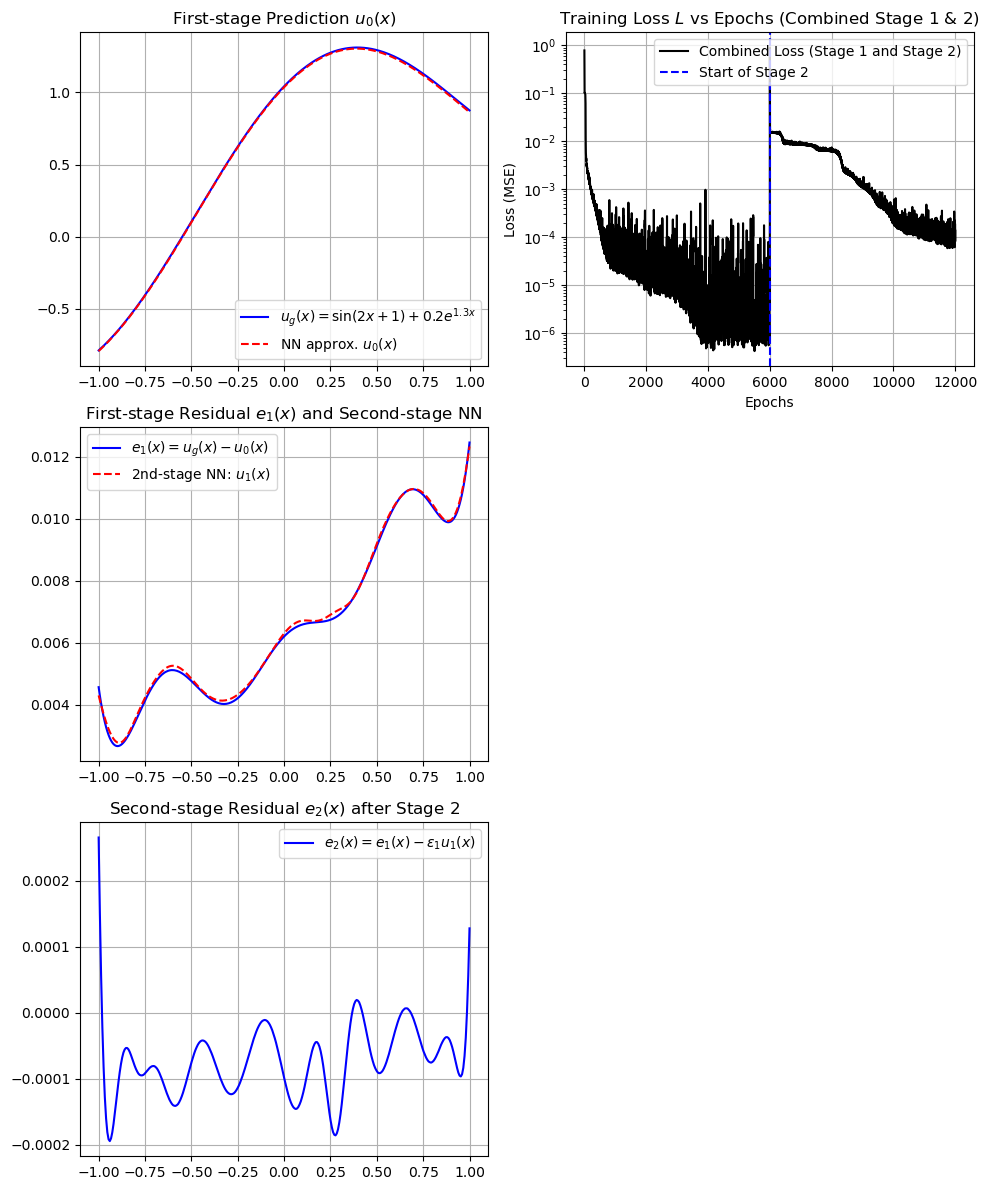

In [9]:
# Plotting the results
plt.figure(figsize=(10, 12))

# Plot (a) Target function vs Stage 1 Prediction
plt.subplot(3, 2, 1)
plt.plot(x_train, y_train, label=r"$u_g(x) = \sin(2x + 1) + 0.2e^{1.3x}$", color='b')
plt.plot(x_train, y_pred1, label="NN approx. $u_0(x)$", color='r', linestyle='--')
plt.title("First-stage Prediction $u_0(x)$")
plt.legend()
plt.grid(True)

# Plot (b) First-stage residual (e1)
plt.subplot(3, 2, 3)
plt.plot(x_train, error1, label=r"$e_1(x) = u_g(x) - u_0(x)$", color='b')
plt.plot(x_train, np.sqrt(np.mean(error1**2)) * y_pred2, label="2nd-stage NN: $u_1(x)$", color='r', linestyle='--')
plt.title("First-stage Residual $e_1(x)$ and Second-stage NN")
plt.legend()
plt.grid(True)

# Plot (c) Second-stage residual (e2)
plt.subplot(3, 2, 5)
plt.plot(x_train, residual_final, label=r"$e_2(x) = e_1(x) - \epsilon_1u_1(x)$", color='b')
plt.title("Second-stage Residual $e_2(x)$ after Stage 2")
plt.legend()
plt.grid(True)

# Plot (d) Combined loss for Stage 1 and Stage 2
# Define the starting epoch of Stage 2 (end of Stage 1 training)
stage2_start_epoch = len(history1.history['loss'])

# Plot (d) Combined loss for Stage 1 and Stage 2
plt.subplot(3, 2, 2)
plt.plot(np.arange(len(combined_loss)), combined_loss, label="Combined Loss (Stage 1 and Stage 2)", color='black')

# Mark transition between Stage 1 and Stage 2
plt.axvline(stage2_start_epoch, color='blue', linestyle='--', label="Start of Stage 2")

plt.yscale("log")
plt.title("Training Loss $L$ vs Epochs (Combined Stage 1 & 2)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()